# ANALIZA FINANSIJSKIH IZVEŠTAJA I DNEVNIKA KNJIŽENJA [demo]
je zasnovana na sledećim podacima:
- DNEVNIK KNJIŽENJA (5 GODINA)
- FINANSIJSKI IZVEŠTAJI (5 GODINA)
- FINANSIJSKI IZVEŠTAJI 5 NAJZNAČAJNIH KONKURENATA (1 GODINA)

Cilj ove analize je testiranje i vizuelizacija rezultata, priprema podataka za Power BI izveštaj, kao i prikaz finansijske analize zasnovane na tri izvora informacija, uz identifikaciju područja koja omogućavaju dalju detaljniju analizu.

Ovaj primer predstavlja sažetu analizu finansijskih podataka kompanije, osmišljenu kao demonstraciju sposobnosti analize podataka korišćenjem dnevnika knjiženja i finansijskih izveštaja.

In [208]:
import json
import requests

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

pd.options.display.float_format = '{:.2f}'.format

In [209]:
# Helper variables
years = [2019, 2020, 2021, 2022, 2023]
current_year = max(years)

## Scripts
# financial components extraction
exec(requests.get("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/src/components.py").text)

# visualization
exec(requests.get("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/src/visualization.py").text)

# # utilities
exec(requests.get("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/src/utilities.py").text)

Kontroler snimanja rezultata analize

In [210]:
save_results = True

Snimanje rezultata analize

In [211]:
save_output = "data/results.json"

In [212]:
def save_result(file_name, key, value):
    try:
        try:
            with open(file_name, 'r', encoding='utf-8') as file:
                data = json.load(file)
        except (FileNotFoundError, json.JSONDecodeError, UnicodeDecodeError):
            try:
                with open(file_name, 'r', encoding='ISO-8859-1') as file:
                    data = json.load(file)
            except (FileNotFoundError, json.JSONDecodeError):
                data = {}

        def make_serializable(obj):
            if isinstance(obj, (np.int64, np.int32, int)):
                return int(obj)
            elif isinstance(obj, (np.float64, np.float32, float)):
                return float(obj)
            elif isinstance(obj, (pd.Timestamp, np.datetime64)):
                return str(obj)
            elif isinstance(obj, dict):
                return {k: make_serializable(v) for k, v in obj.items()}
            elif isinstance(obj, list):
                return [make_serializable(i) for i in obj]
            return obj

        data[key] = make_serializable(value)

        with open(file_name, 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=4)

    except Exception as e:
        print(f"Greška: {e}")

### Učitavanje podataka

#### Učitavanje petogodišnjih podatka iz dnevnika knjiženja u objedinjenih u DataFrame.

In [213]:
df_list = []

for year in years:
    df_list.append(pd.read_parquet(f"https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/data/parquet/financial_journal_{year}.parquet"))

df_ledgers = pd.concat(df_list, ignore_index=True)

df_ledgers.head()

,date,account,debit,credit
0,1/1/2019,01200,2224922.81,0.00
1,1/1/2019,01200,1852233.24,0.00
2,1/1/2019,01200,13485.83,0.00
3,1/1/2019,01900,0.00,2644852.98
4,1/1/2019,02200,56193212.58,0.00


#### Učitavanje finansijskih izveštaja kompanije.

In [214]:
df_financial_reports = pd.read_parquet("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/data/parquet/financial_reports.parquet")
df_financial_reports

fr_header = years.copy()

fr_header.insert(0, "AOP") if "AOP" not in fr_header else None
fr_header.insert(1, "description") if "description" not in fr_header else None

df_financial_reports.columns = fr_header

df_financial_reports.head()

,AOP,description,2019,2020,2021,2022,2023
0,0001,Upisani a neuplaćeni kapital,0,0,0,0,0
1,0002,STALNA IMOVINA,114790,101222,91204,81606,77543
2,0003,NEMATERIJALNA IMOVINA,5537,2329,2953,3190,1631
3,0004,Ulaganja u razvoj,0,0,0,0,0
4,0005,"Koncesije, patenti, licence, robne i uslužne m...",5537,2329,2953,3190,1631


#### Učitavanje finansijskih izveštaja 5 izabranih konkurenata.

In [215]:
df_competitors = pd.read_parquet("https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/data/parquet/competitors_fr.parquet")

df_competitors.head()

,AOP,description,competitor_1,competitor_2,competitor_3,competitor_4,competitor_5
0,0001,Upisani a neuplaćeni kapital,0,0,0,0,0
1,0002,STALNA IMOVINA,160770,87822,253512,17935,467292
2,0003,NEMATERIJALNA IMOVINA,84,225,0,0,1072
3,0004,Ulaganja u razvoj,0,0,0,0,967
4,0005,"Koncesije, patenti, licence, robne i uslužne m...",84,225,0,0,105


#### Učitavanje mape naziva konta

Mapa konta neće biti korišćena u ovoj analizi, ali pruža korisnicima koji nisu upoznati sa kontnim okvirom korisnu referencu, omogućavajući im da prepoznaju na koji se konto odnosi određeni podatak.

In [216]:
example_account_key = '010'

account_map_url = "https://raw.githubusercontent.com/JovicaB/financial_analysis_example/refs/heads/main/data/accounts_map.json"

response = requests.get(account_map_url)
account_map_dict = response.json()

print(f"Naziv konta {example_account_key} je: {account_map_dict[example_account_key]}")

Naziv konta 010 je: Ulaganja u razvoj


## 1. Čišćenje podataka

Izvezeni podaci su već sređeni (s obzirom na to da su rezultat finansijskih promena firme tokom godine i izvezeni su iz knjigovodstvenog softvera), osim  početnog i krajnjeg stanja koje je potrebno isključiti iz dataset-a, jer predstavljaju duplirane vrednosti zbog prenosa početnog stanja (duplirane vrednosti u odnosu na prošlu godinu) i završnih knjiženja (duplirane vrednosti stanja tekuće godine zbog balansiranja vrednosti aktive i pasive).

Finansijski izveštaji kompanije i konkurenata su izvezeni sa sajta Agencije za privredne registre te ih nije potrebno dodatno sređivati.

Napomena: S obzirom na to da identifikator završnih knjiženja nije poznat, nisu sva završna knjiženja uklonjena, međutim završna knjiženja klasa 5 i 6 se nalaze na suprotnoj strani što neće imati uticaj na analizu.

In [217]:
# Excluding data from January 1st and grouping accounts for closing entries under 599 and 699.
df = df_ledgers.copy()

df['date'] = pd.to_datetime(df['date'])

df = df[~((df['date'].dt.month == 1) & (df['date'].dt.day == 1))]
df = df[~(df['account'].str.startswith(('599', '699', '7')))]

df = df.reset_index(drop=True)

df.head()

,date,account,debit,credit
0,2019-01-02,34100,95074521.37,0.00
1,2019-01-02,34001,0.00,95074521.37
2,2019-01-02,023102,662752.75,0.00
3,2019-01-02,029302,0.00,44183.52
4,2019-01-02,22820,-295000.00,0.00


#### Određivanje materijalnosti radi izbora materijalno značajnih pozicija bilansa stanja za analizu.

In [218]:
# The materiality factor is 5% of total business revenue (in thousands of RSD).
materiality_factor = 0.05
materiality = round(df_financial_reports[df_financial_reports['AOP'] == '1001'].iloc[0, -1] * materiality_factor, 2)
materiality

63524.6

In [219]:
# Balance sheet: material positions
result = df_financial_reports[
    (df_financial_reports.iloc[:, -1] > materiality) &
    (~df_financial_reports['AOP'].str.startswith('1'))
]['description'].to_list()

result = [item.upper() for item in result]
result

['STALNA IMOVINA',
 'NEKRETNINE, POSTROJENJA I OPREMA',
 'OBRTNA IMOVINA',
 'ZALIHE',
 'ROBA',
 'POTRAŽIVANJA PO OSNOVU PRODAJE',
 'POTRAŽIVANJA OD KUPACA U ZEMLJI',
 'UKUPNA AKTIVA',
 'KAPITAL',
 'NERASPOREĐENI DOBITAK',
 'NERASPOREĐENI DOBITAK RANIJIH GODINA',
 'KRATKOROČNA REZERVISANJA I KRATKOROČNE OBAVEZE',
 'KRATKOROČNE FINANSIJSKE OBAVEZE',
 'OBAVEZE PO OSNOVU KREDITA OD DOMAĆIH BANAKA',
 'OBAVEZE IZ POSLOVANJA',
 'OBAVEZE PREMA DOBAVLJAČIMA U ZEMLJI',
 'UKUPNA PASIVA']

In [220]:
# financial components class instance
fr_components_class_obj = ComponentsFR(df_financial_reports)

# visualization class instance
visualization_class_obj = FinancialDataVisualization

## 2. Osnovni finansijski podaci

In [221]:
df_customers_mask = ((df['account'].str.startswith(('200', '201', '204', '205'))) &
                  df['account'].str.contains('-') &
                  (df['date'].dt.year == 2023))

df_customers = df[df_customers_mask]
customers_count = df_customers['account'].value_counts()
df_customers_total = df_customers.groupby('account').agg({'debit': 'sum'}).reset_index()
material_customers = df_customers_total[df_customers_total['debit'] > materiality]

osnovni_finansijski_podaci = {
    "naziv_kompanije": "Test",
    "vrednost_prihoda": fr_components_class_obj.prihod_od_prodaje(current_year),
    "vrednost_rashoda": fr_components_class_obj._get_aop_value('1013', current_year),
    "neto_dobit": fr_components_class_obj._get_aop_value('1055', current_year),
    "materijalnost": materiality,
    "broj_zaposlenih": fr_components_class_obj.broj_zaposlenih(current_year),
    "broj_kupaca_ukupno": len(customers_count),
    "broj_materijalno_znacajnih_kupaca": material_customers.shape[0]
}

if save_results:
    save_result(save_output, "osnovni_podaci", [osnovni_finansijski_podaci])

osnovni_finansijski_podaci

{'naziv_kompanije': 'Test',
 'vrednost_prihoda': 1270492,
 'vrednost_rashoda': 1224624,
 'neto_dobit': 53163,
 'materijalnost': 63524.6,
 'broj_zaposlenih': 48,
 'broj_kupaca_ukupno': 961,
 'broj_materijalno_znacajnih_kupaca': 508}

### Prihodi/rashodi/dobit

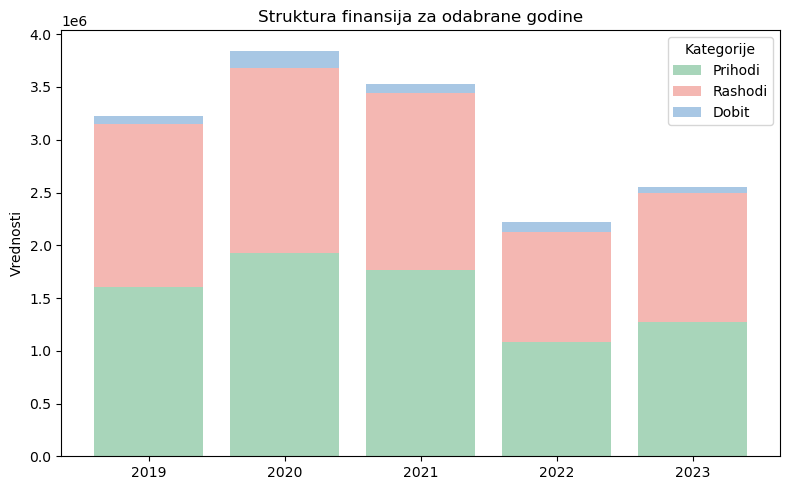

In [222]:
data = []
for year in years[:]: 
    prihodi = fr_components_class_obj.prihod_od_prodaje(year)
    rashodi = fr_components_class_obj._get_aop_value('1013', year)
    dobit = fr_components_class_obj._get_aop_value('1055', year)
    data.append([prihodi, rashodi, dobit])

data = np.array(data) 
categories = ["Prihodi", "Rashodi", "Dobit"]
x = np.arange(len(years[:])) 

colors = ['#A8D5BA', '#F4B7B2', '#A8C7E4']

fig, ax = plt.subplots(figsize=(8, 5))

bottoms = np.zeros(len(x)) 
for i, category in enumerate(categories):
    ax.bar(x, data[:, i], bottom=bottoms, color=colors[i], label=category)
    bottoms += data[:, i] 

ax.set_xticks(x)
ax.set_xticklabels(years[:5])
ax.set_ylabel("Vrednosti")
ax.set_title("Struktura finansija za odabrane godine")
ax.legend(title="Kategorije")

plt.tight_layout()
plt.show()

DETALJNA ANALIZA: 
- Iz pregleda podataka za 2020. godinu uočavamo da je dobit poslovanja bila veća u odnosu na prethodnu i narednu godine. Ovaj trend sugeriše da su tokom trajanja pandemije COVID-19 operativni troškovi bili niži ili je razlika u ceni bila veća, što otvara prostor za detaljniju analizu i utvrđivanje uzroka ove pojave.
- Takođe, interesesantna je i 2022 godina za detaljnu analizu jer je dobit veća u odnosu na prethodnu i narednu godinu sa značajno nižim prihodima, ali i značajno nižim rashodima. Istražiti faktore uticaja na povećanje marže poslovanja uz smanjen obrt poslovanja, što može imati pozitivan efekat na optimizaciju troškova u narednim periodima.

In [223]:
# save financial structure results
basic_financial_structure = []

for year in years:
    basic_financial_structure.append(
        {
            "godina": year,
            "prihodi": fr_components_class_obj.prihod_od_prodaje(year),
            "rashodi": fr_components_class_obj._get_aop_value('1013', year),
            "dobit": fr_components_class_obj._get_aop_value('1055', year)
        }
    )

if save_results:
    save_result(save_output, "godisnja_finansijska_struktura", basic_financial_structure)

basic_financial_structure_df = pd.DataFrame(basic_financial_structure)

basic_financial_structure_df

,godina,prihodi,rashodi,dobit
0,2019,1600822,1550690,71303
1,2020,1928890,1752394,163459
2,2021,1765372,1678526,81723
3,2022,1087184,1038027,98519
4,2023,1270492,1224624,53163


## 2.A. Analiza finansijskih izveštaja

### 2.A.1. Komparativni pregled

- Prvi grafikon prikazuje poređenje poslovanja analizirane kompanije za poslednjih 5 godina.
- Drugi grafikon prikazuje poređenje poslovanja poslednje godine pet najvažnijih konkurenata i poslovanje analizirane kompanije, kompanija klijenta je označena zelenom bojom.
- Dodatni linijski grafikon pokazuje prihode kompanije, odnosno prihode konkurencije

Pet godina finansijskih rezultata možda nije dovoljno da bismo sa utvrdili korelaciju sa visokim nivoom pouzdanosti, ali vizuelnim uvidom u komparativne pozicije prihoda u odnosu na druge finansijske stavke, možemo pretpostaviti povezanost varijabli, što nam pruža dovoljno informacija ze kreiranje hipoteze detaljnije analize.

In [224]:
# Common Variables for Comparative Visualization
revenue_result = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "1001", years)

company_revenue = revenue_result[0]
competition_revenue = revenue_result[1]

company_revenue

,2019,2020,2021,2022,2023
0,1600822,1928890,1765372,1087184,1270492


Petogodišnji prihodi kompanije i prihodi konkurencije u odnosu na prihod kompanije za poslednju godinu poslovanja

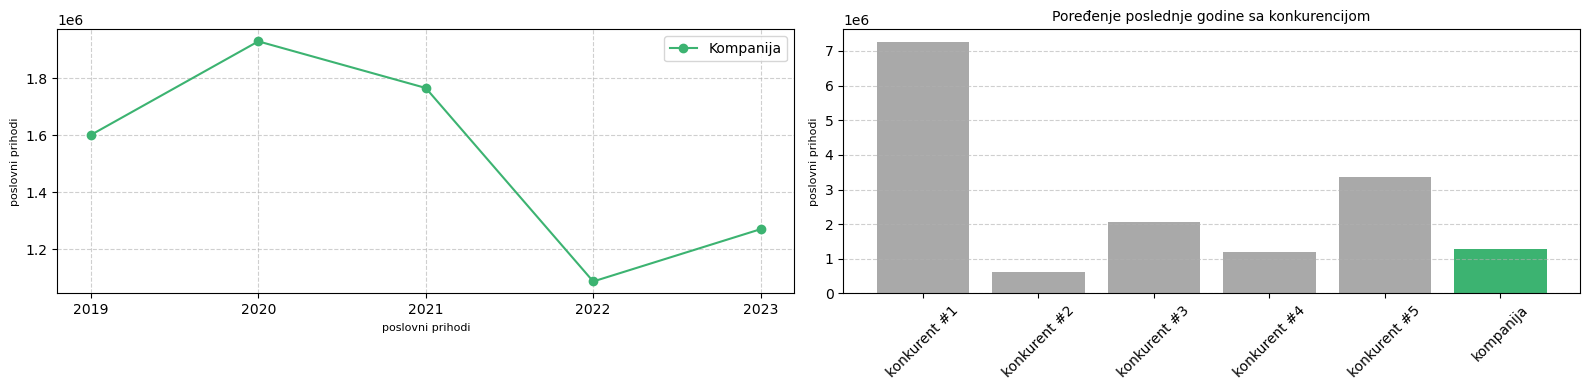

In [225]:
if save_results:
  save_result(save_output, "petogodisnji_prihodi", company_revenue.iloc[0].to_dict())
  save_result(save_output, "prihodi_konkurencije", competition_revenue.iloc[0].to_dict())

# Visuelization
visualization_class_obj.comparative_analysis_visualization(company_revenue, competition_revenue, 'poslovni prihodi')

### Stalna imovina i prihodi

Ovi uporedni rezultati ističu efikasnost upotrebe osnovnih sredstava, poređenjem osnovnih sredstava i prihoda. Prvi grafikon prikazuje paralelne trendove u ulaganjy u osnovna sredstva i prihode tokom poslednjih pet godina za preduzeće, u poređenju sa ulaganjima u osnovna sredstva konkurencije u njihovoj poslednjoj godini poslovanja.

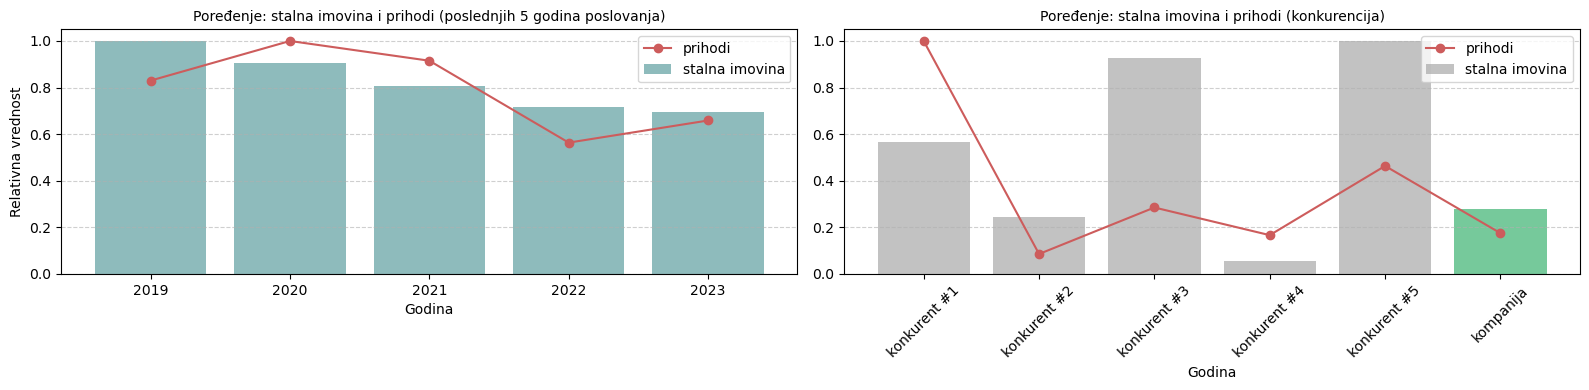

In [226]:
result_fixed_assets = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "0009", years)

fixed_assets_company = result_fixed_assets[0]
fixed_assets_competition = result_fixed_assets[1]

df_fix_assets_combined_company = pd.concat([fixed_assets_company, company_revenue])
df_fix_assets_combined_competitors = pd.concat([fixed_assets_competition, competition_revenue])
df_swapped = df_fix_assets_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

if save_results:
  save_result(save_output, "petogodisnja_osnovna_sredstva", [fixed_assets_company.iloc[0].to_dict()])
  save_result(save_output, "osnovna_sredstva_konkurencije", [fixed_assets_competition.iloc[0].to_dict()])

visualization_class_obj.comparative_analysis_visualization_with_revenue(df_fix_assets_combined_company, df_swapped, "stalna imovina")

### Zalihe i prihodi

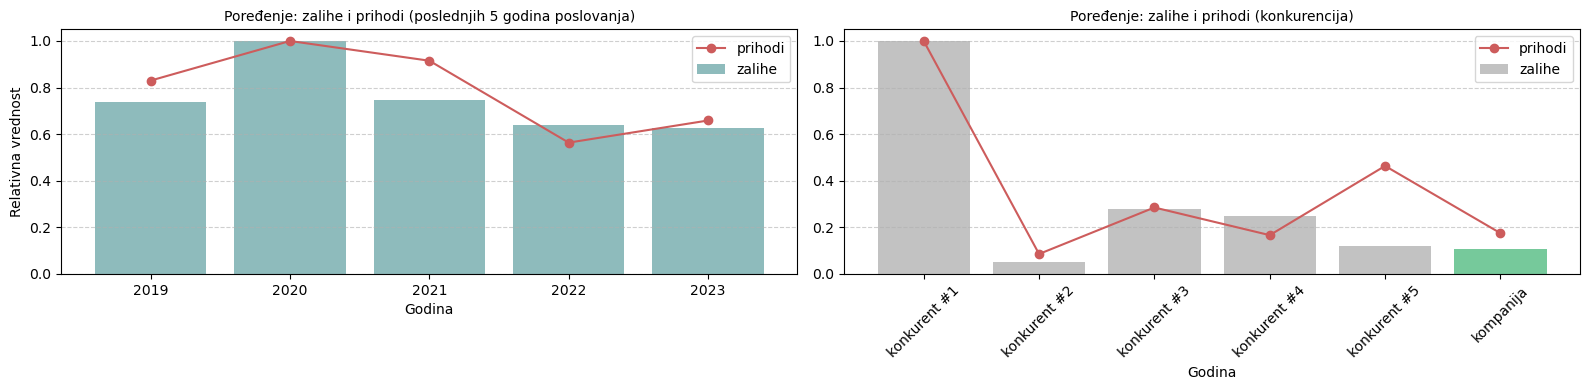

In [227]:
## Inventory from sales
result_inventory = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "0034", years)

inventory_company = result_inventory[0]
inventory_competition = result_inventory[1]

df_inventory_combined_company = pd.concat([inventory_company, company_revenue])
df_inventory_combined_competitors = pd.concat([inventory_competition, competition_revenue])
df_swapped = df_inventory_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "petogodisnje_zalihe", [inventory_company.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_zalihe", [inventory_competition.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.comparative_analysis_visualization_with_revenue(df_inventory_combined_company, df_swapped, "zalihe")

Na osnovu grubog poređenja stanja zaliha i prihoda možemo da pretpostavimo paralelno kretanje zaliha i prihoda. Neobična vrednost je primećena kod konkurenta broj 5, koji se izdvaja kao relativno ekstreman primer sa niskim prihodima i visokom vrednošću zaliha. Dalja analiza ovog slučaja je opravdana jer bi mogla da pruži odgovor na pitanje o potencijalnim posledicama gomilanja zaliha, uključujući rizike povezane sa održivošću poslovanja, likvidnošću i mogućim uticajem na profitabilnost. Ovo bi uključivalo proveru petogodišnjeg finansijskih informacija konkurenta broj 5 (s obzirom na dostupnost ovih podataka u APR-u).

### Obaveze iz poslovanja i prihodi

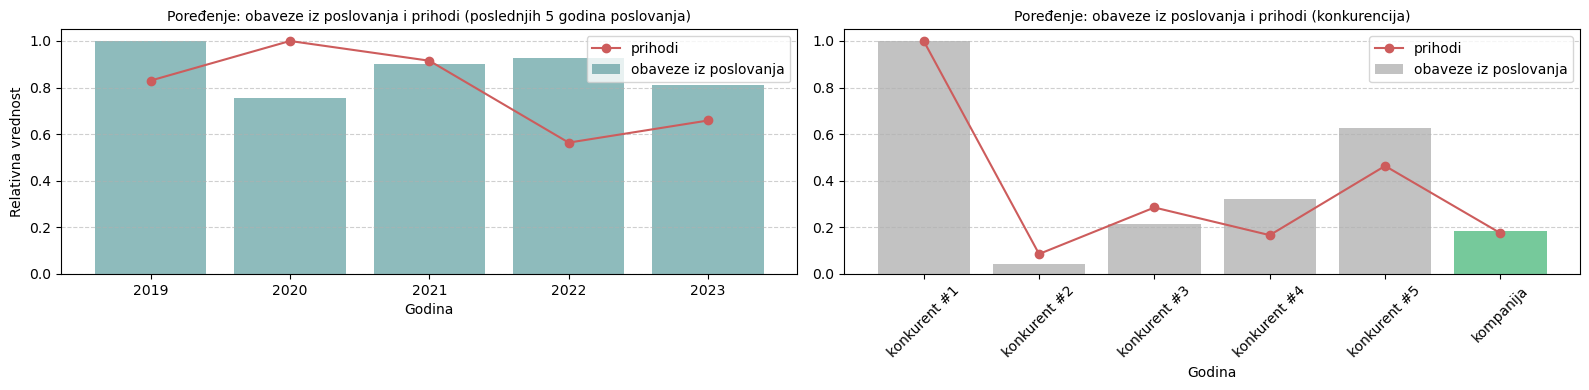

In [228]:
## Operational_liabilities
result_operational_liabilities = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "0442", years)

operational_liabilities_company = result_operational_liabilities[0]
operational_liabilities_competition = result_operational_liabilities[1]

df_operational_liabilities_combined_company = pd.concat([operational_liabilities_company, company_revenue])
df_operational_liabilities_combined_competitors = pd.concat([operational_liabilities_competition, competition_revenue])
df_swapped = df_operational_liabilities_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "petogodisnje_obaveze_iz_poslovanja", [operational_liabilities_company.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_zobaveze_iz_poslovanja", [operational_liabilities_competition.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.comparative_analysis_visualization_with_revenue(df_operational_liabilities_combined_company, df_swapped, "obaveze iz poslovanja")

### Krediti i prihodi

Izvor hipoteze za dalju analizu leži u ispitivanju stepenu efikasnosti korišćenja kredita, odnosno u analizi uticaja pozajmljivanja na generisanje prihoda.

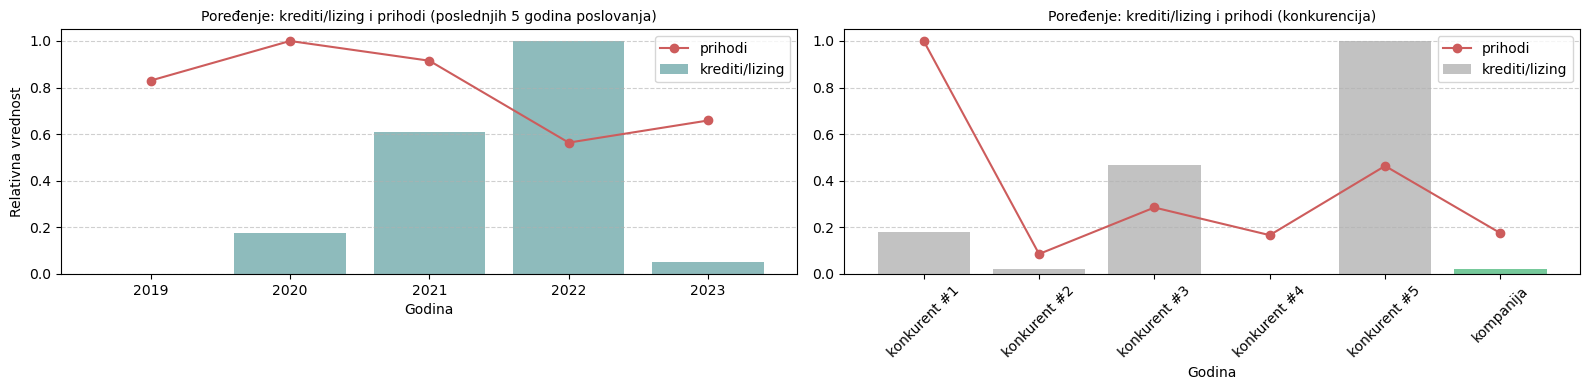

In [229]:
## Credits from banks & Leasing
result_credits = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "0420", years)

credits_company = result_credits[0]
credits_competition = result_credits[1]

df_credits_combined_company = pd.concat([credits_company, company_revenue])
df_credits_combined_competitors = pd.concat([credits_competition, competition_revenue])
df_swapped = df_credits_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "petogodisnji_krediti", [credits_company.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_krediti", [credits_competition.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.comparative_analysis_visualization_with_revenue(df_credits_combined_company, df_swapped, "krediti/lizing")

Preciznija analiza: Efekti kredita, posebno dugoročnih se mogu videti tek narednih godina, ovo bi uključilo i izbacivanje dela lizinga koji nije za delatnost i kratkoročnih kredita za likvidnost iz vrednosti za poređenje.

### Zaposleni i prihodi

Analiza odnosa između broja zaposlenih i prihoda može pružiti vredne uvide u efikasnost rada i njen uticaj na generisanje prihoda. Dalje istraživanje moglo bi se fokusirati na to kako promene u broju zaposlenih, uz držanje drugih faktora konstantnim, koreliraju sa promenama u prihodima. Ova analiza mogla bi pomoći u identifikaciji osnovnih trendova ili neefikasnosti koje utiču na ukupne performanse.

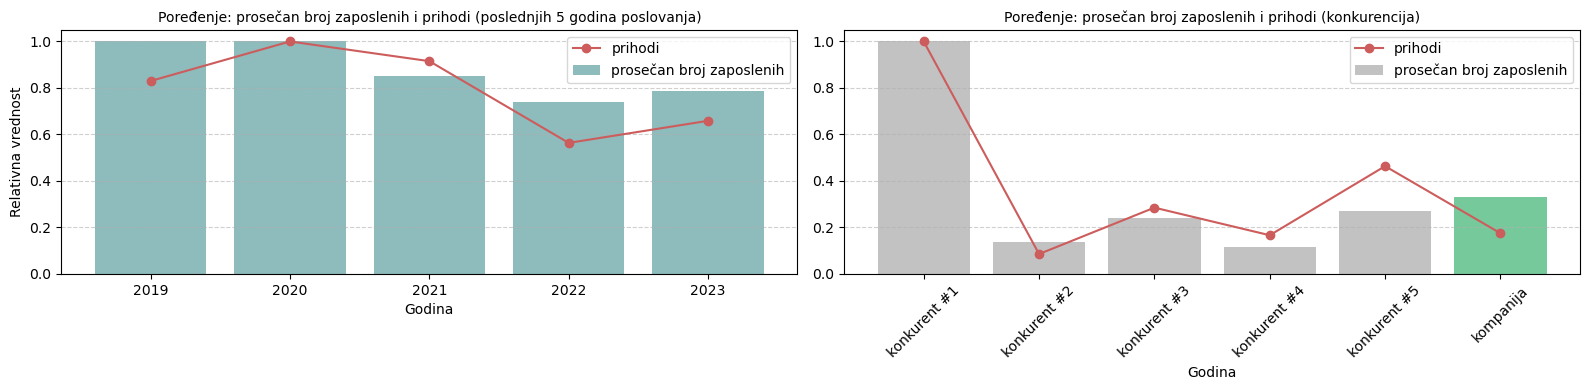

In [230]:
## Employees
result_employees = visualization_class_obj.aggregate_data_for_comparative_visualization(df_financial_reports, df_competitors, "9005", years)

employees_company = result_employees[0]
employees_competition = result_employees[1]

df_employees_combined_company = pd.concat([employees_company, company_revenue])
df_employees_combined_competitors = pd.concat([employees_competition, competition_revenue])
df_swapped = df_employees_combined_competitors.iloc[[1, 0]].reset_index(drop=True)

# save results
if save_results:
  save_result(save_output, "petogodisnji_broj_zaposlenih", [employees_company.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_broj_zaposlenih", [employees_competition.iloc[0].to_dict()])

visualization_class_obj.comparative_analysis_visualization_with_revenue(df_employees_combined_company, df_swapped, "prosečan broj zaposlenih")

Iz vizualizacije broja zaposlenih i prihoda kompanije, kao i komparativnog pregleda sa konkurentima, može se uočiti povezanost između broja zaposlenih i visine prihoda. Međutim, detaljnija analiza efikasnosti broja zaposlenih zahtevala bi dodatne informacije o strukturi radnih mesta, ulozi pojedinih sektora u stvaranju prihoda, kao i o produktivnosti po zaposlenom. Ovi podaci bi omogućili precizniju procenu kako broj zaposlenih utiče na ukupne prihode i kako se ta efikasnost može optimizovati.

### 2.A.2. Racio analiza

In [231]:
# Ratio analysis class instance

ratio_analysis_class_obj_company = RatioAnalysis(df_financial_reports, ComponentsFR)
ratio_analysis_class_obj_competition = RatioAnalysis(df_competitors, ComponentsFR)

labels_company = years.copy()
labels_competition = ['competitor_1', 'competitor_2', 'competitor_3', 'competitor_4', 'competitor_5', 'company']

# Prepare ratio analysis results for visualization
def ratio_results(ratio_name):
    company_ratio_method = getattr(ratio_analysis_class_obj_company, ratio_name)
    competitors_ratio_method = getattr(ratio_analysis_class_obj_competition, ratio_name)

    company_ratio = company_ratio_method()
    competitors_ratio = competitors_ratio_method()

    competitors_ratio.append(company_ratio[-1])

    company_ratio_df = pd.DataFrame([company_ratio], columns=labels_company)
    competitors_ratio_df = pd.DataFrame([competitors_ratio], columns=labels_competition)

    return company_ratio_df, competitors_ratio_df

#### Likvidnost

Trenutni racio (Current Ratio)

finansijski pokazatelj koji meri sposobnost kompanije da pokrije svoje kratkoročne obaveze koristeći svoja kratkoročna sredstva. Izračunava se kao odnos tekuće imovine i tekućih obaveza, a idealno je da bude veći od 1, što znači da kompanija ima dovoljno sredstava za izmirivanje svojih dugova.

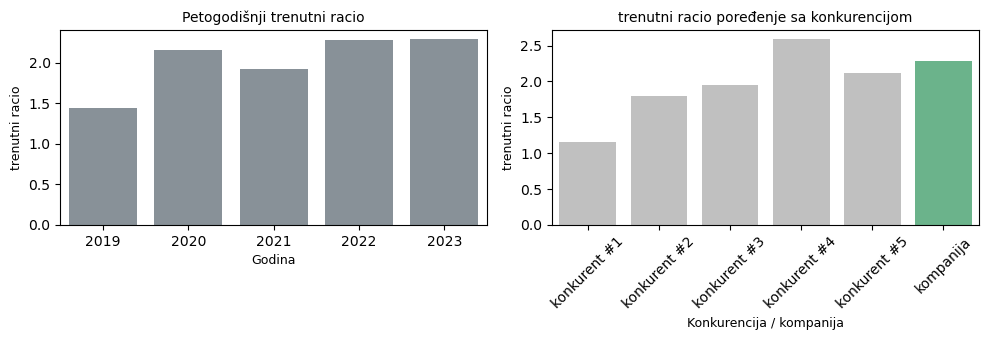

In [232]:
current_ratio_company_df, current_ratio_competitors_df = ratio_results("current_ratio")

if save_results:
  save_result(save_output, "petogodisnji_trenutni_racio", [current_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_trenutni_racio", [current_ratio_competitors_df.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.barplot_ratio_analysis(current_ratio_company_df, current_ratio_competitors_df, 'trenutni racio', 'g')

Brzi racio (Quick Ratio)

pokazatelj likvidnosti koji meri sposobnost preduzeća da izdrži kratkoročne obaveze bez oslanjanja na prodaju zaliha. Računava se kao odnos tekućih aktiva (izuzev zaliha) i tekućih obaveza, a vrednost veća od 1 ukazuje na zdravu finansijsku situaciju.

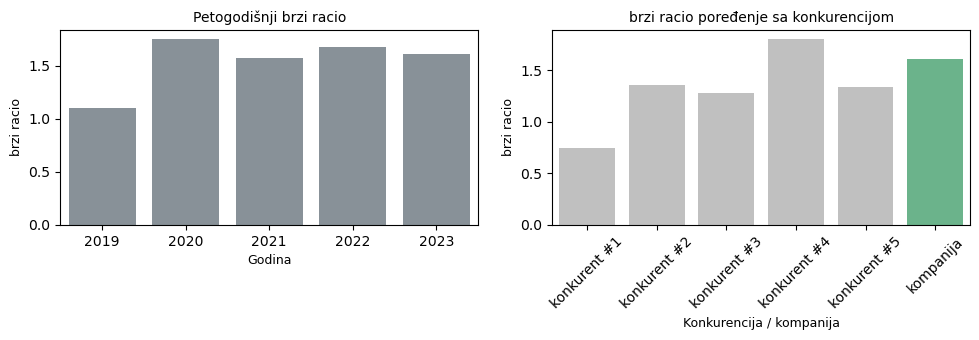

In [233]:
quick_ratio_company_df, quick_ratio_competitors_df = ratio_results("quick_ratio")

if save_results:
  save_result(save_output, "petogodisnji_brzi_racio", [quick_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_brzi_racio", [quick_ratio_competitors_df.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.barplot_ratio_analysis(quick_ratio_company_df, quick_ratio_competitors_df, 'brzi racio', 'g')

#### Solventnost

Racio dugoročnog duga (Long Term Debt Ratio)

meri udeo dugoročnog duga u ukupnim aktivima preduzeća, ukazujući na njegovu zavisnost od dugoročnog finansiranja. Viša vrednost ovog pokazatelja može ukazivati na veću finansijsku polugu i potencijalni rizik, dok niža vrednost sugeriše manju zavisnost od duga za finansiranje rasta.

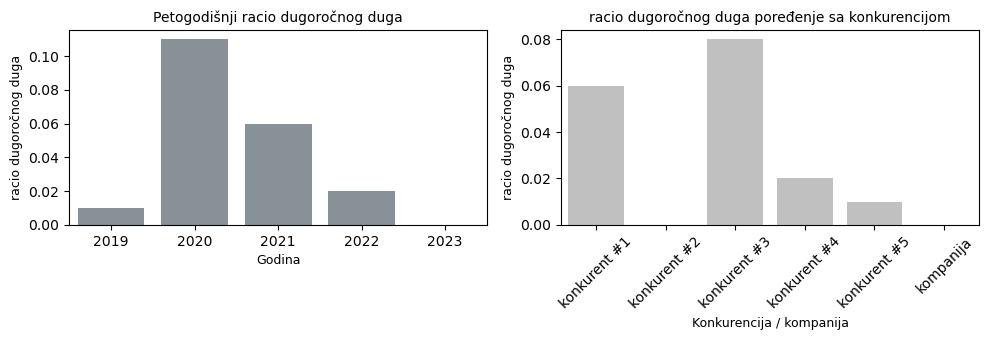

In [234]:
lt_debt_ratio_company_df, lt_debt_ratio_competitors_df = ratio_results("long_term_debt_ratio")

if save_results:
  save_result(save_output, "petogodisnji_racio_dugorocnog_duga", [lt_debt_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_racio_dugorocnog_duga", [lt_debt_ratio_competitors_df.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.barplot_ratio_analysis(lt_debt_ratio_company_df, lt_debt_ratio_competitors_df, 'racio dugoročnog duga', 'g')

Racio duga u odnosu na kapital (Debt to Equity)

pokazuje odnos između duga preduzeća i njegovog vlasničkog kapitala. Ovaj pokazatelj meri nivo zaduženosti preduzeća u odnosu na investicije vlasnika, gde viša vrednost može ukazivati na veću finansijsku polugu i potencijalni rizik za investitore.

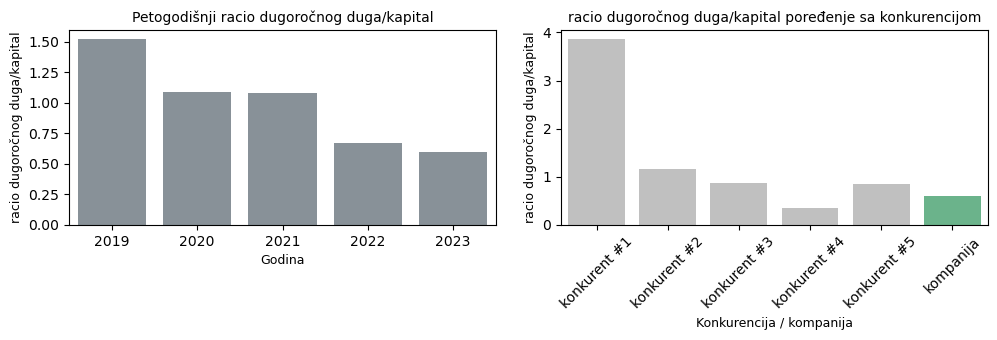

In [235]:
debt_to_equity_ratio_company_df, debt_to_equity_ratio_competitors_df = ratio_results("debt_to_equity")

if save_results:
  save_result(save_output, "petogodisnji_racio_dug_kapital", [debt_to_equity_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_racio_dug_kapital", [debt_to_equity_ratio_competitors_df.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.barplot_ratio_analysis(debt_to_equity_ratio_company_df, debt_to_equity_ratio_competitors_df, 'racio dugoročnog duga/kapital', 'g')

#### Profitabilnost

Racio bruto profitne marže (Gross Profit Margin)

pokazuje koliko preduzeće zadržava kao bruto profit od svake jedinice prihoda nakon što pokrije troškove proizvodnje ili nabavke. Ovaj pokazatelj ukazuje na efikasnost preduzeća u kontroli svojih proizvodnih ili nabavnih troškova u odnosu na ukupne prihode.

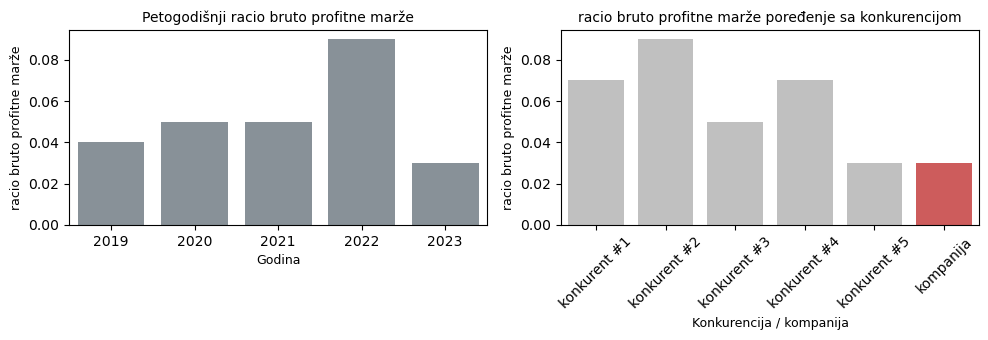

In [236]:
gp_margin_ratio_company_df, gp_margin_ratio_competitors_df = ratio_results("gross_profit_margin")

if save_results:
  save_result(save_output, "petogodisnji_gross_margin", [gp_margin_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_gross_margin", [gp_margin_ratio_competitors_df.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.barplot_ratio_analysis(gp_margin_ratio_company_df, gp_margin_ratio_competitors_df, 'racio bruto profitne marže', 'r')

Racio neto profitne marže (Net Profit Margin)

meri koliki procenat prihoda preduzeće zadržava kao neto profit nakon što su svi troškovi, porezi i drugi izdaci oduzeti. Ovaj pokazatelj ukazuje na ukupnu profitabilnost preduzeća i njegovu sposobnost da ostvaruje profit od svakog prihoda.

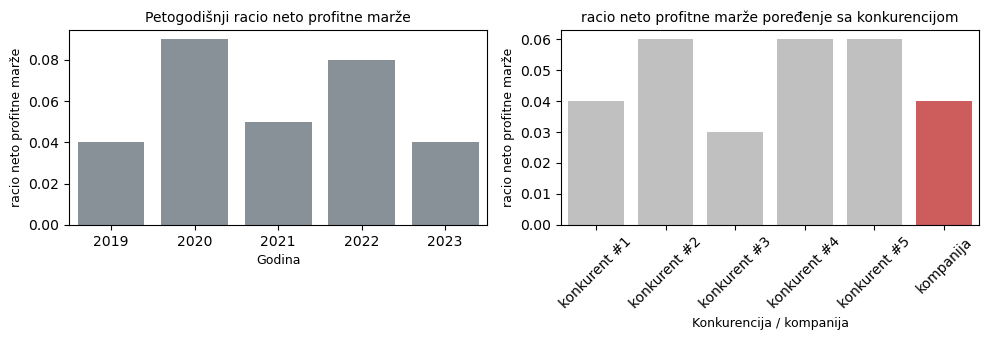

In [237]:
np_margin_ratio_company_df, np_margin_ratio_competitors_df = ratio_results("net_profit_margin")

if save_results:
  save_result(save_output, "petogodisnji_net_margin", [np_margin_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_net_margin", [np_margin_ratio_competitors_df.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.barplot_ratio_analysis(np_margin_ratio_company_df, np_margin_ratio_competitors_df, 'racio neto profitne marže', 'r')

Racio povrata na poslovnu imovinu (Return on Bussiness Assets - ROBA)

meri koliko profit preduzeće ostvaruje u odnosu na svoju osnovnu poslovnu imovinu, isključujući nepotrebnu imovinu kao što je novac i kratkoročna potraživanja. Ovaj pokazatelj pomaže u oceni efikasnosti korišćenja resursa specifičnih za poslovne operacije u generisanju dobiti.

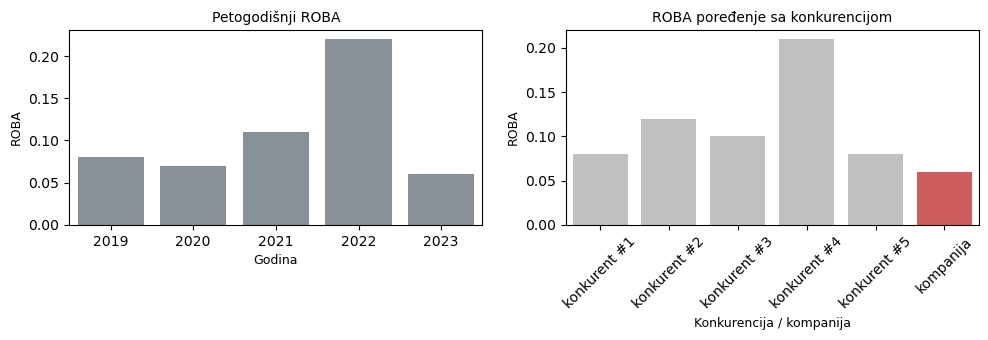

In [238]:
roa_ratio_company_df, roa_ratio_competitors_df = ratio_results("return_on_bussines_assets")

if save_results:
  save_result(save_output, "petogodisnji_ROBA", [roa_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_ROBA", [roa_ratio_competitors_df.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.barplot_ratio_analysis(roa_ratio_company_df, roa_ratio_competitors_df, 'ROBA', 'r')

Racio povrata na kapital (Return on Equity-ROE)

pokazatelj koji meri profitabilnost preduzeća u odnosu na kapital koji su uložili njegovi akcionari. ROE pokazuje koliko preduzetje zaradi za svaku jedinicu uloga akcionara, što je koristan indikator za procenu efikasnosti u korišćenju vlasničkog kapitala.

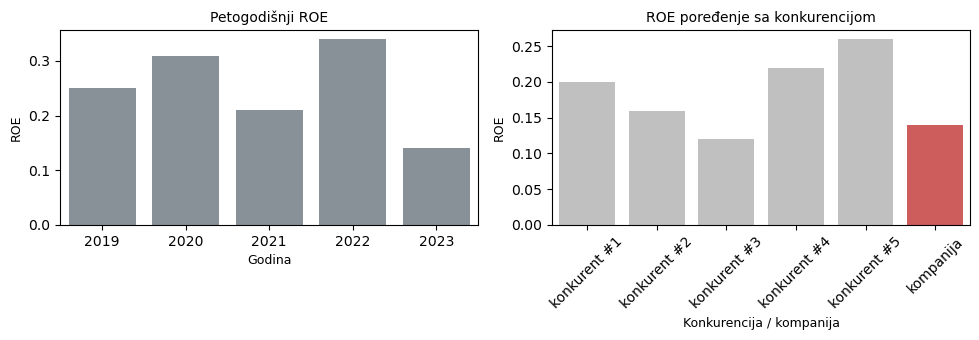

In [239]:
roe_ratio_company_df, roe_ratio_competitors_df = ratio_results("return_on_equity")

if save_results:
  save_result(save_output, "petogodisnji_ROE", [roe_ratio_company_df.iloc[0].to_dict()])
  save_result(save_output, "konkurencija_ROE", [roe_ratio_competitors_df.iloc[0].to_dict()])

# Visuelization
visualization_class_obj.barplot_ratio_analysis(roe_ratio_company_df, roe_ratio_competitors_df, 'ROE', 'r')

## 2.B. Analiza dnevnika knjiženja

### 2.B.1. Prihodi i rashodi

Struktura prihoda i rashoda

In [240]:
# Prihodi
df_revenue_2023 = df[(df['date'].dt.year == 2023) & (df['account'].str.startswith('6'))]
revenue_structure = (df_revenue_2023.groupby(df_revenue_2023['account'].str[:2])['credit']
          .sum()
          .loc[lambda x: x >= 1]
          .to_dict())
sum_revenue = sum(revenue_structure.values())

revenue_structure_result = {key: round(value/sum_revenue, 2) for key, value in revenue_structure.items()}
df_revenue_structure = pd.DataFrame(revenue_structure_result.items(), columns=['account_group', 'value'])
revenue_structure_result

# Rashodi
df_expenses_2023 = df[(df['date'].dt.year == 2023) & (df['account'].str.startswith('5'))]
expenses_structure = (df_expenses_2023.groupby(df_expenses_2023['account'].str[:2])['debit']
          .sum()
          .loc[lambda x: x >= 1]
          .to_dict())
sum_expenses = sum(expenses_structure.values())

expenses_structure_result = {key: round(value/sum_expenses, 2) for key, value in expenses_structure.items()}
df_expenses_structure = pd.DataFrame(expenses_structure_result.items(), columns=['account_group', 'value'])

if save_results:
  save_result(save_output, "struktura_prihoda", [revenue_structure_result])
  save_result(save_output, "struktura_rashoda", [expenses_structure_result])
  
df_revenue_structure

,account_group,value
0,60,0.95
1,61,0.03
2,62,0.00
3,65,0.00
4,66,0.00
5,67,0.01
6,68,0.01


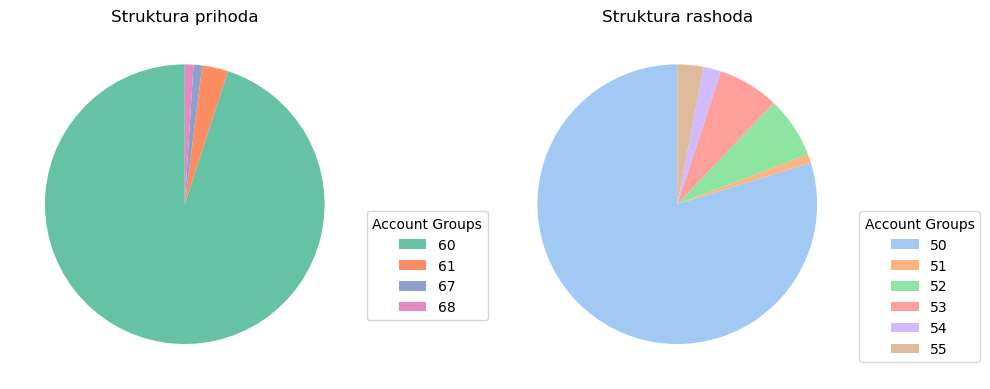

In [241]:
account_group_revenue = df_revenue_structure['account_group']
values_revenue = df_revenue_structure['value']

account_group_expenses = df_expenses_structure['account_group']
values_expense = df_expenses_structure['value']

filtered_groups_revenue = [str(group) for group, value in zip(account_group_revenue, values_revenue) if value > 0]
filtered_values_revenue = [value for value in values_revenue if value > 0]

filtered_groups_expense = [str(group) for group, value in zip(account_group_expenses, values_expense) if value > 0]
filtered_values_expense = [value for value in values_expense if value > 0]

# Visuelization
colors_revenue = sb.color_palette("Set2", len(filtered_values_revenue))
colors_expense = sb.color_palette("pastel", len(filtered_values_expense))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(filtered_values_revenue, labels=None, autopct=None, startangle=90, colors=colors_revenue)
ax1.set_title("Struktura prihoda")

ax2.pie(filtered_values_expense, labels=None, autopct=None, startangle=90, colors=colors_expense)
ax2.set_title("Struktura rashoda")

ax1.legend(filtered_groups_revenue, title="Account Groups", loc="upper left", bbox_to_anchor=(1, 0.5))
ax2.legend(filtered_groups_expense, title="Account Groups", loc="upper left", bbox_to_anchor=(1, 0.5))

plt.tight_layout() 
plt.show()


### 2.B.2. Inventar

Ulaz i izlaz zaliha robe

In [242]:
df_inventory = df[(df['date'].dt.year == 2023) &
                 (df['account'].str.startswith('13'))].copy()

df_inventory['week'] = df_inventory['date'].dt.isocalendar().week

result = df_inventory.groupby('week').agg({'debit': 'sum', 'credit': 'sum'}).reset_index()

inv_in_out = result.loc[:, ['debit', 'credit']] = round(result[['debit', 'credit']] / 1000)

# Prepare save results
json_result = [
        {"week": row['week'], "debit": row['debit'], "credit": row['credit']}
        for _, row in result.iterrows()
    ]

if save_results:
    save_result(save_output, "52-nedeljni_ulaz_izlaz_inventara", json_result)

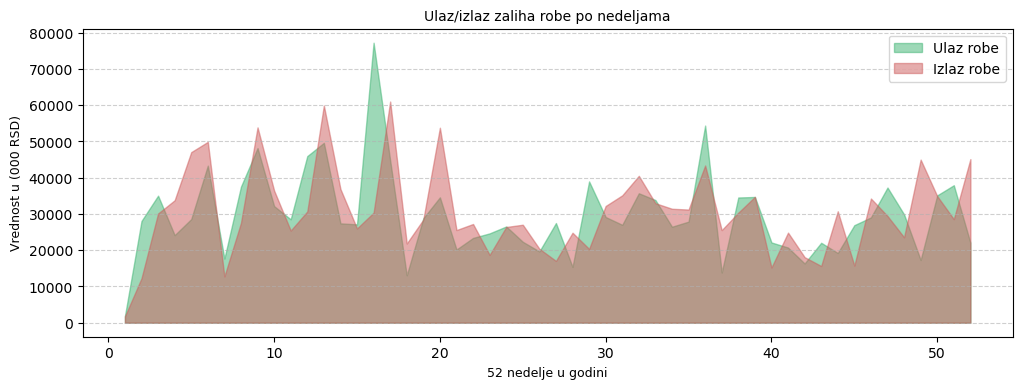

In [243]:
# Visualization
plt.figure(figsize=(12, 4))

plt.fill_between(result['week'], result['debit'], label='Ulaz robe', color='MediumSeaGreen', alpha=0.5)
plt.fill_between(result['week'], result['credit'], label='Izlaz robe', color='IndianRed', alpha=0.5)

plt.title('Ulaz/izlaz zaliha robe po nedeljama', fontsize=10)
plt.xlabel('52 nedelje u godini', fontsize=9)
plt.ylabel('Vrednost u (000 RSD)', fontsize=9)

plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Napomena: Detaljniju analizu efikasnosti nabavke i optimizaciju upravljanja zalihama je moguće uraditi sa dodatnim podacima iz pomoćnih knjiga lagera/inventara.

### 2.B.3. Gotovina

Gotovina tokom godine

Posmatramo stanje gotovine na nedeljnom nivou, bez kumulativnog prikaza i početnog stanja, kako bismo utvrdili da li postoji prekomerno zadržavanje neiskorišćene gotovine.

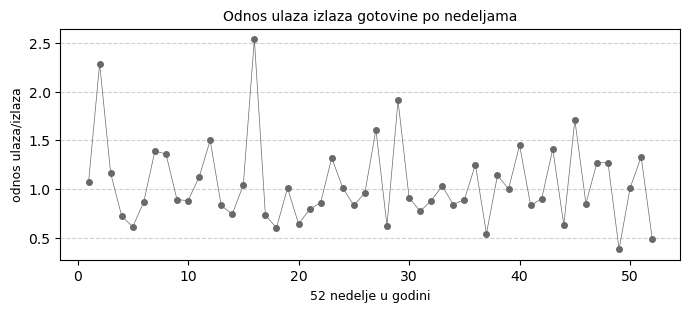

In [244]:
df_cash = df[(df['date'].dt.year == 2023) &
                 (df['account'].str.startswith('24'))].copy()

df_cash['week'] = df_cash['date'].dt.isocalendar().week

cash_result = df_cash.groupby('week').agg({'debit': 'sum', 'credit': 'sum'}).reset_index()

cash_result.loc[:, ['debit', 'credit']] = result[['debit', 'credit']] / 1000
cash_result['debit_to_credit'] = result['debit'] / result['credit']

cash_result = cash_result[['week', 'debit_to_credit']].assign(debit_to_credit=cash_result['debit_to_credit'].round(2))

# Prepare save results
json_result = [
        {"week": row['week'], "debit_to_credit": row['debit_to_credit']}
        for _, row in cash_result.iterrows()
    ]

if save_results:
    save_result(save_output, "52-nedeljni_neto_inventar", json_result)

# Visuelization
plt.figure(figsize=(8, 3))

plt.plot(cash_result['week'], cash_result['debit_to_credit'], marker='o', linestyle='-', linewidth=0.5, color='DimGray', markersize=4)

plt.title('Odnos ulaza izlaza gotovine po nedeljama', fontsize=10)
plt.xlabel('52 nedelje u godini', fontsize=9)
plt.ylabel('odnos ulaza/izlaza', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

Iako je neto vrednost gotovine u 10. nedelji povećana za oko tri puta, može se zaključiti da je ta gotovina već u narednom periodu iskorišćena.

Detaljnija analiza bi se odnosila na utvrđivanje faktora efikasnog korišćenja gotovine u poslovanju.

### 2.B.4. Kupci

In [245]:
customers_df = df.copy()

customers_df['month'] = customers_df['date'].dt.month
# customers_df['week'] = customers_df['date'].dt.isocalendar().week # ne valja ISO kalendar imam 53 nedelje

customers_df['week'] = ((customers_df['date'].dt.dayofyear - 1) // 7 + 1) % 52
customers_df['week'] = customers_df['week'].replace(0, 52) 

account_condition = (
    (customers_df['account'].str.startswith('200') & ~customers_df['account'].str.startswith('2009')) |
    (customers_df['account'].str.startswith('201') & ~customers_df['account'].str.startswith('2019')) |
    (customers_df['account'].str.startswith('204') & ~customers_df['account'].str.startswith('2049')) |
    (customers_df['account'].str.startswith('205') & ~customers_df['account'].str.startswith('2059'))
)

mask = (
    account_condition &
    (customers_df['debit'] > 0)
)

customers_df = customers_df[mask]
customers_df = customers_df.drop(columns=['credit'])
customers_df_2023 = customers_df[customers_df['date'].dt.year == 2023].copy()

# Prepare save results
monthly_sum = customers_df_2023.groupby('month')['debit'].sum() / 1000
monthly_sum = monthly_sum.reset_index()

monthly_sum['debit'] = monthly_sum['debit'].round()

months = monthly_sum['month'].to_list()
debit_sums = monthly_sum['debit'].to_list()

json_result = [{"month": key, "customers_sum": value} for key, value in zip(months, debit_sums)]

if save_results:
    save_result(save_output, "12-mesecna_suma_kupaca", json_result)

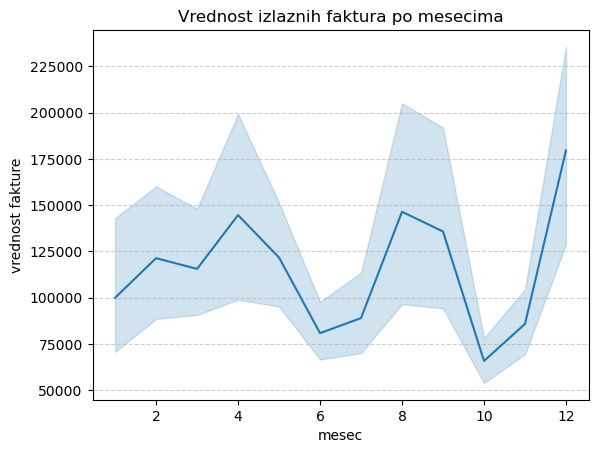

In [246]:
# Visuelization
ax = sb.lineplot(data=customers_df_2023, x='month', y='debit')

ax.set(xlabel='mesec')
ax.set(ylabel='vrednost fakture')
ax.set(title='Vrednost izlaznih faktura po mesecima')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Grafikon prikazuje vrednost izlaznih faktura po mesecima ukazuje na to da su april (4),  avgust (8) i decembar (12) specifični zbog izraženije vrednosti i varijabilnosti vrednosti faktura u poređenju sa ostalim mesecima. Ova pojava je vizuelno istaknuta širim opsegom (senkom) oko linije trenda za ove mesece.

Moguća dalja interpretacija i analiza mogla bi obuhvatiti istraživanje sezonskih faktora, promena u strukturi kupaca, poređenje sa prethodnim godinama i druge relevantne aspekte. Cilj ovih istraživanja bio bi utvrđivanje uzroka ovih odstupanja, a ukoliko su sistemske prirode, njihovo iskorišćavanje za povećanje prihoda u narednim periodima.

#### Domaći kupci prema stranim kupcima

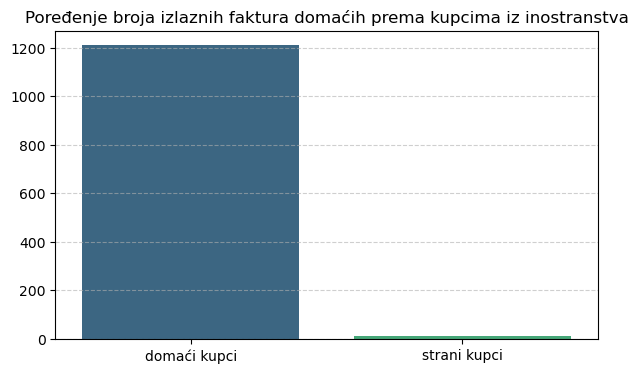

In [247]:
d_mask = (
    (customers_df['account'].str.startswith('200')) | (customers_df['account'].str.startswith('204'))
)

f_mask = (
    (customers_df['account'].str.startswith('201')) | (customers_df['account'].str.startswith('205'))
)

customers_df['week'].unique()
d_customers_df = customers_df[d_mask]
f_customers_df = customers_df[f_mask]

# Prepare save results
data = [d_customers_df['account'].nunique(), f_customers_df['account'].nunique()]
labels = ['domaći kupci', 'strani kupci']

json_result = [
    {
        'domaci_kupci': d_customers_df['account'].nunique(),
        'strani_kupci': f_customers_df['account'].nunique()
    }
]

if save_results:
    save_result(save_output, "domaci_prema_stranim_kupcima", json_result)

# Visuelization
plt.figure(figsize=(7, 4))
sb.barplot(x=labels, y=data, hue=labels, palette='viridis')
plt.title("Poređenje broja izlaznih faktura domaćih prema kupcima iz inostranstva")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [248]:
d_weekly_sum = d_customers_df.groupby('week')['debit'].sum().reset_index()
f_weekly_sum = f_customers_df.groupby('week')['debit'].sum().reset_index()

weeks = list(range(1, 53))
d_values = d_weekly_sum['debit'].to_list()
f_values = f_weekly_sum['debit'].to_list()

# fix for values because sometimes there are less then 52 summed values (no values in that period)
d_values = d_values + [0] * (52 - len(d_values)) if len(d_values) < 52 else d_values[:52]
f_values = f_values + [0] * (52 - len(f_values)) if len(f_values) < 52 else f_values[:52]

json_result = [{"week": week, "domestic_customers": d_value, "foreign_customer": f_value} for week, d_value, f_value in zip(weeks, d_values, f_values)]

if save_results:
    save_result(save_output, "52-nedeljna_suma_kupaca_domaci_strani", json_result)

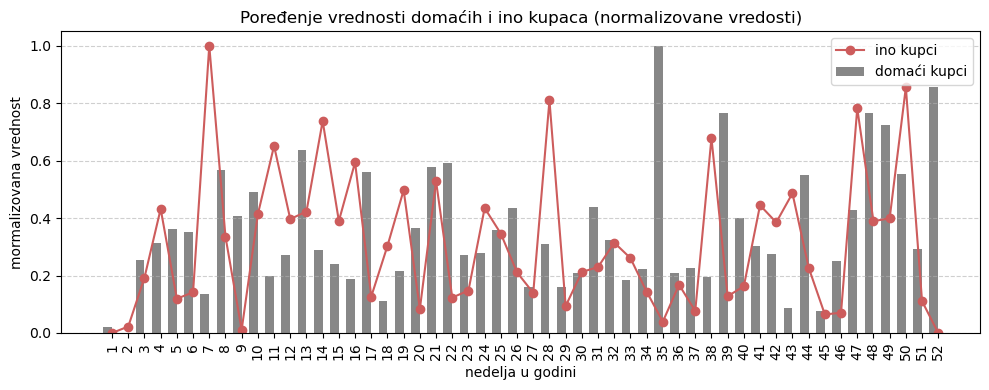

In [249]:
# Values normalization
d_values_normalized = (d_weekly_sum['debit'] - d_weekly_sum['debit'].min()) / (d_weekly_sum['debit'].max() - d_weekly_sum['debit'].min())
f_values_normalized = (f_weekly_sum['debit'] - f_weekly_sum['debit'].min()) / (f_weekly_sum['debit'].max() - f_weekly_sum['debit'].min())

d_values_normalized = d_values_normalized.tolist() + [0] * (52 - len(d_values_normalized))
f_values_normalized = f_values_normalized.tolist() + [0] * (52 - len(f_values_normalized))

# Vizualization
bar_width = 0.55
weeks = np.arange(1, 53)

plt.figure(figsize=(10, 4))

plt.bar(weeks - bar_width / 2, d_values_normalized, width=bar_width, label='domaći kupci', color='DimGray', alpha=0.8)
plt.plot(weeks, f_values_normalized, label='ino kupci', color='IndianRed', marker='o', linewidth=1.5)

plt.xlabel('nedelja u godini')
plt.ylabel('mormalizovana vrednost')
plt.title('Poređenje vrednosti domaćih i ino kupaca (normalizovane vredosti)')
plt.xticks(weeks, rotation=90)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Vrednosti prikazane u ovom paralelnom grafikonu su normalizovane vrednosti i ne predstavljaju stvarne vrednosti domaćih i stranih kupaca. Cilj vizelne prezentacije je poređenje osclacija vrednosti domaćih i stranih kupaca po nedeljama u godini, kako bismo mogli utvrditi potencijalne paterne povezanosti, odnosno zajedničko povećanje ili smanjenje vrednosti domaćih i stranih kupaca u određenom periodu godine.

#### Stari kupci prema novim kupcima

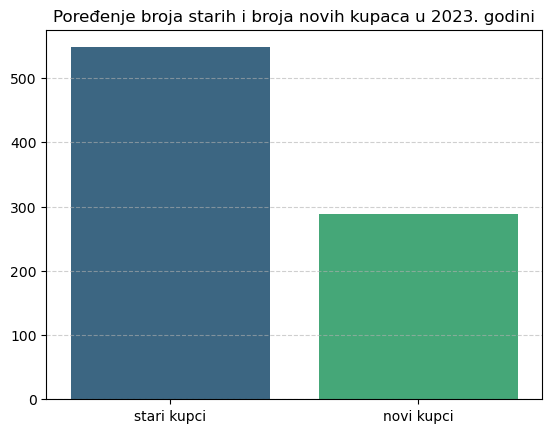

In [250]:
date_filter = customers_df['date'].dt.year == 2022
account_filter = customers_df['account'].str.startswith('2') & customers_df['account'].str.contains('-')

old_customers_lst = customers_df[date_filter & account_filter]['account'].to_list()

old_customers = customers_df_2023[customers_df_2023['account'].isin(old_customers_lst)]
new_customers = customers_df_2023[~customers_df_2023['account'].isin(old_customers_lst)]

data = [old_customers['account'].nunique(), new_customers['account'].nunique()]

save_data = [{
    "broj_starih_kupaca": data[0],
    "broj_novih_kupaca": data[1]
}]

if save_results:
    save_result(save_output, "broj_starih_novih_kupaca", save_data)

# Visuelization
labels = ['stari kupci', 'novi kupci']
sb.barplot(x=labels, y=data, hue=labels, palette='viridis')
plt.title("Poređenje broja starih i broja novih kupaca u 2023. godini")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Vrednost starih i novih kupaca (komparativni pregled)

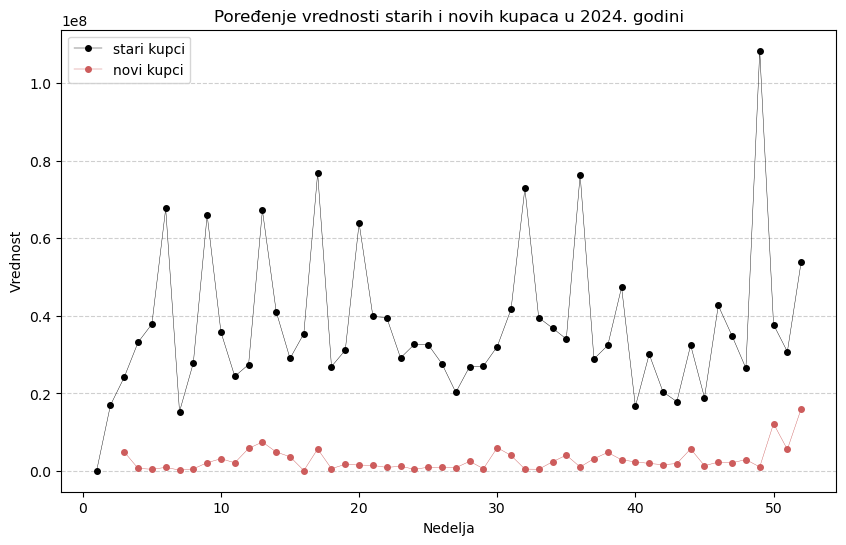

In [251]:
old_weekly_sum = old_customers.groupby('week')['debit'].sum().reset_index()
new_weekly_sum = new_customers.groupby('week')['debit'].sum().reset_index()

# Data preparation for saving
weeks = list(range(1, 53))
old_customers_values = old_weekly_sum['debit'].to_list()
new_customer_values = new_weekly_sum['debit'].to_list()

# fix for values there are less then 52 summed values (no values in that period)
old_c_values = old_customers_values + [0] * (52 - len(old_customers_values)) if len(old_customers_values) < 52 else old_customers_values[:52]
new_c_values = new_customer_values + [0] * (52 - len(new_customer_values)) if len(new_customer_values) < 52 else new_customer_values[:52]

json_result = [{"week": week, "old_customers": o_value, "new_customers": n_value} for week, o_value, n_value in zip(weeks, old_c_values, new_c_values)]

if save_results:
    save_result(save_output, "vrednost_star_novi_kupci", json_result)

# Visuelization
plt.figure(figsize=(10, 6))

plt.plot(old_weekly_sum['week'], old_weekly_sum['debit'], lw = 0.3, label='stari kupci', color='Black', marker='o', markersize=4)

plt.plot(new_weekly_sum['week'], new_weekly_sum['debit'], lw = 0.3, label='novi kupci', color='IndianRed', marker='o', markersize=4)

plt.xlabel('Nedelja')
plt.ylabel('Vrednost')
plt.title('Poređenje vrednosti starih i novih kupaca u 2024. godini')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Bez ulaska u detaljnu analizu kupaca, na osnovu uvida u brojnost i vrednost starih i novih kupaca, može se doneti zaključak da je brojnost i vrednost kupaca sa kojima postoji dugogodišnji odnos značajno veća. Ovi kupci, iako možda ne doprinose značajnom širenju tržišta, čine osnovu za generisanje glavnog dela prihoda kompanije. Stoga bi ovi kupci trebali biti prioritet u daljoj analizi u cilju održavanja postojećih odnosa, jer dugoročno predstavljaju stabilnost i siguran izvor prihoda. Takođe, primetan je skok u vrednosti kupaca, starih i novih, u završnim nedeljama godine. Neophodna je potvrda ovog pravila proverom prethodnih godina, da bi se sa pouzdano optimizovalo stanje zaliha za kraj godine.

#### Frekvencija kupovine ili vrednost transakcija?

S obzirom na to da smo identifikovali kupce na koje treba staviti fokus, naredni korak u analizi bio bi utvrđivanje da li ti kupci imaju veći uticaj kroz prosečnu frekvenciju kupovine ili vrednost pojedinačnih faktura.

In [252]:
# old cutomers
mask = ((old_customers['account'].str.startswith('200')) | (old_customers['account'].str.startswith('204')))

old_domestic_customers_df = old_customers[mask]

account_stats = old_domestic_customers_df.groupby(['account', 'month', 'week']).agg(
    frequency=('account', 'count'),
    avg_value=('debit', 'mean')
).reset_index()

monthly_stats = account_stats.groupby('month').agg(
    total_frequency=('frequency', 'sum'),
    avg_value_per_month=('avg_value', 'mean')
).reset_index().assign(
    avg_value_per_month=lambda x: x['avg_value_per_month'].round(2)
)


# Prepare save results
months = list(range(1, 13))
customers_frequency = monthly_stats['total_frequency'].to_list()
customer_avg_value = monthly_stats['avg_value_per_month'].to_list()

json_result = [{"month": month, "monthly_customers_invoice_requency": freq, "monthly_customers_avg_value": avg_val} for month, freq, avg_val in zip(months, customers_frequency, customer_avg_value)]

if save_results:
    save_result(save_output, "mesecna_frekfencija_prosecnavrednost", json_result)

Vizuelno će biti prikazani rezultati frekfencije i prosečnih vrednosti faktura po mesecima ali između njih nema povezanosti.

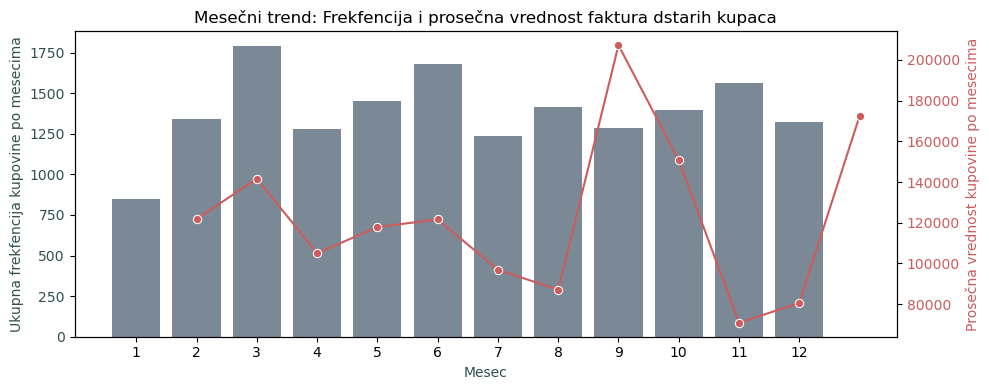

In [253]:
monthly_stats = account_stats.groupby('month').agg(
    total_frequency=('frequency', 'sum'),
    avg_value_per_month=('avg_value', 'mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 4))

sb.barplot(x='month', y='total_frequency', data=monthly_stats, color='LightSlateGrey', ax=ax1)
ax1.set_ylabel('Ukupna frekfencija kupovine po mesecima', color='DarkSlateGray')
ax1.tick_params(axis='y', labelcolor='DarkSlateGray')

ax2 = ax1.twinx()
sb.lineplot(x='month', y='avg_value_per_month', data=monthly_stats, color='IndianRed', marker='o', ax=ax2)
ax2.set_ylabel('Prosečna vrednost kupovine po mesecima', color='IndianRed')
ax2.tick_params(axis='y', labelcolor='IndianRed')

ax1.set_xlabel('Mesec', color='DarkSlateGray')
plt.title('Mesečni trend: Frekfencija i prosečna vrednost faktura dstarih kupaca')
plt.tight_layout()
plt.show()


In [254]:
correlation = account_stats[['avg_value', 'frequency']].corr()

correlation

,avg_value,frequency
avg_value,1.00,-0.01
frequency,-0.01,1.00


Korelacija između frekvencije i prosečne vrednosti faktura je vrlo negativna iniska (-0.00866), što ukazuje na odsustvo značajne linearne povezanosti. Veća učestalost kupovina ne znači nužno i veće prosečne vrednosti faktura, niti obrnuto.

Dalju analizu kupaca možemo usmeriti na poređenje dana naplate za četiri grupe kupaca (domaći-strani-stari-novi), kao i na identifikaciju faktora na koje možemo uticati, a koji bi imali značajan uticaj na zadržavanje postojećih i sticanje novih kupaca.

### Detaljna analiza

**Dalja analiza može obuhvatiti širok spektar oblasti, zavisno od dubine i ciljeva. Fokus može biti usmeren na ključne metrike koje će pružiti  uvide za donošenje poslovnih odluka, uzimajući u obzir specifične potrebe kompanije.**